<a href="https://colab.research.google.com/github/simran029/ImageVista/blob/master/ImageCaptioning_Using_Inception_Resnet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Load data
#images_dir = os.listdir("/My Drive/Colab Notebooks")
images_dir = os.listdir("/content/gdrive/My Drive/Colab Notebooks/MAJOR/flickr8k/Flickr_Data/Flickr_Data/")

images_path = '/content/gdrive/My Drive/Colab Notebooks/MAJOR/flickr8k/Flickr_Data/Flickr_Data/Images/'
captions_path = '/content/gdrive/My Drive/Colab Notebooks/MAJOR/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = '/content/gdrive/My Drive/Colab Notebooks/MAJOR/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = '/content/gdrive/My Drive/Colab Notebooks/MAJOR/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = '/content/gdrive/My Drive/Colab Notebooks/MAJOR/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [0]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

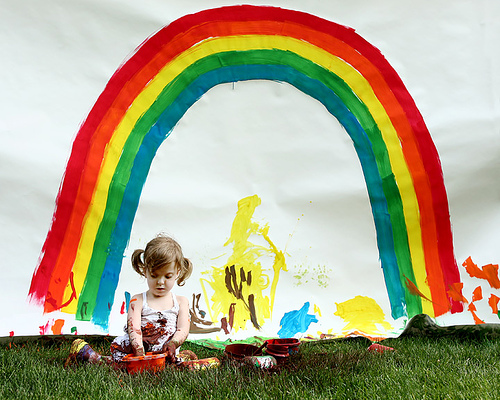

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [5]:
# displaying an image and captions given to it
temp = captions[10].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [6]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")


18

In [0]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [8]:
#model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model = InceptionResNetV2(include_top=False, weights='imagenet',input_shape=(224,224,3), pooling='avg')
model.summary()
# Note: For more details on ResNet50 architecture you can click on hyperlink given below














219062272/219055592 [==============================] - 3s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      


In [0]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [12]:
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(1536)
    train_data[ix] = pred

1000
2000
3000


In [13]:
train_data['2513260012_03d33305cf.jpg'].shape

(1536,)

In [0]:
# opening train_encoded_images.p file and dumping it's content
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )  

In [15]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [16]:
pd_dataset.head()

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [17]:
# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

30000


In [18]:
# First 5 captions stored in sentences
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [0]:
# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
words = [i.split() for i in sentences]

In [20]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [21]:
# Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253
indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'
print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(word_2_indices['<end>'])
print(indices_2_word[8051])

6362
pad
3470
stroll


In [22]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [23]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [24]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

(30000,)
(30000,)


In [25]:
print(padded_sequences[0])

[[6362    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6362 2445    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6362 2445 5966    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6362 2445 5966 7057    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6362 2445 5966 7057 2681    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [26]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[0][ix][iy]],)
    print("\n")

print(len(padded_sequences[0]))

<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
running
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<sta

In [0]:
num_of_images = 2000
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [28]:
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [0]:
f= open('/content/gdrive/My Drive/Colab Notebooks/MAJOR/flickr8k/train_encoded_images.p', 'rb')
encoded_images = pickle.load(f, encoding="bytes")

In [30]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0].encode() in encoded_images.keys():
#         print(ix, encoded_images[ds[ix, 0].encode()])
        imgs.append(list(encoded_images[ds[ix, 0].encode()]))

imgs = np.asarray(imgs)
print(imgs.shape)

(15000, 2048)


In [31]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(25493, 2048)


In [32]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

25493


In [33]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [34]:
images = np.load("images.npy")

print(images.shape)
(25493, 2048)
imag = np.load("image_names.npy")
        
print(imag.shape)

(25493, 2048)
(25493,)


In [0]:
embedding_size = 128
max_len = 40

In [41]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [38]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056512   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [42]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_5_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      1056512     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          262272      dense_5_input[0][0]              
____________________________________________________________________________________________

In [43]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=30)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
25493/25493 [==============================] - 344s 13ms/step - loss: 5.7014 - acc: 0.0739
Epoch 2/30
25493/25493 [==============================] - 327s 13ms/step - loss: 5.1906 - acc: 0.1175
Epoch 3/30
25493/25493 [==============================] - 321s 13ms/step - loss: 5.2456 - acc: 0.0848
Epoch 4/30
25493/25493 [==============================] - 327s 13ms/step - loss: 5.1373 - acc: 0.0977
Epoch 5/30
25493/25493 [==============================] - 338s 13ms/step - loss: 5.0886 - acc: 0.0976
Epoch 6/30
25493/25493 [==============================] - 335s 13ms/step - loss: 5.1246 - acc: 0.0830
Epoch 7/30
25493/25493 [==============================] - 330s 13ms/step - loss: 4.9320 - acc: 0.1096
Epoch 8/30
25493/25493 [==============================] - 345s 14ms/step - loss: 4.9823 - acc: 0.0898
Epoch 9/30
25493/25493 [==============================] - 341s 13ms/step - loss: 4.8145 

In [0]:
model.save_weights("model_weights.h5")

In [0]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [0]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [62]:
from keras.applications.resnet50 import ResNet50
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')


94658560/94653016 [==============================] - 2s 0us/step


In [0]:
img = "/content/drive/My Drive/Colab Notebooks/MAJOR/flickr8k/Flickr_Data/Flickr_Data/Images/1453366750_6e8cf601bf.jpg"

test_img = get_encoding(resnet, img)

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])



In [0]:
Argmax_Search = predict_captions(test_img)

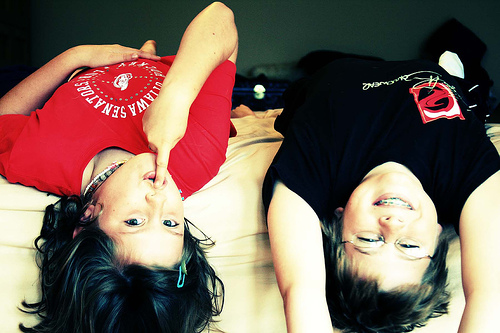

Two children are upside upside a a .


In [67]:
z = Image(filename=img)
display(z)

print(Argmax_Search)

In [0]:
img = "/content/drive/My Drive/Colab Notebooks/20190622_151928.jpg"

test_img2 = get_encoding(resnet, img)

In [69]:
test_captions = list()
for i in x_test:
    if i in tokens:
        test_captions.append(tokens[i])
        
print(test_captions[:5])

[['The dogs are in the snow in front of a fence .', 'The dogs play on the snow .', 'Two brown dogs playfully fight in the snow .', 'Two brown dogs wrestle in the snow .', 'Two dogs playing in the snow .'], ['a brown and white dog swimming towards some in the pool', 'A dog in a swimming pool swims toward sombody we cannot see .', 'A dog swims in a pool near a person .', 'Small dog is paddling through the water in a pool .', 'The small brown and white dog is in the pool .'], ['A man and a woman in festive costumes dancing .', 'A man and a woman with feathers on her head dance .', 'A man and a woman wearing decorative costumes and dancing in a crowd of onlookers .', 'one performer wearing a feathered headdress dancing with another performer in the streets', 'Two people are dancing with drums on the right and a crowd behind them .'], ['A couple of people sit outdoors at a table with an umbrella and talk .', 'Three people are sitting at an outside picnic bench with an umbrella .', 'Three pe

In [73]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [76]:
predicted_captions = list()
images_path='/content/gdrive/My Drive/Colab Notebooks/MAJOR/flickr8k/Flickr_Data/Flickr_Data/Images/'
for i in x_test:
    if i is not "":
        x = images_path + i
        test_img = get_encoding(resnet, x)
        #print(img_path)
        predicted_captions.append(predict_captions(test_img))
    
predicted_captions[:5]

['Two dogs playing on the the .',
 'A man is in a a a the the water .',
 'A boy in a a a a a a a a a .',
 'A woman in on a a a a .',
 'A football player in red red and is a a red red red red red red red red red red red red red red red red red red red red red red red red red red red red red']

In [0]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

In [78]:
# bleu score
score1 = corpus_bleu(test_captions, predicted_captions,weights=(1, 0, 0, 0))
score2 = sentence_bleu(test_captions, predicted_captions,weights=(1, 0, 0, 0))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
score1 = corpus_bleu(test_captions, predicted_captions,weights=(1, 0, 0, 0))
score2 = corpus_bleu(test_captions, predicted_captions,weights=(0.5,0.5, 0, 0))
score3 = corpus_bleu(test_captions, predicted_captions,weights=(0.33, 0.33, 0.33, 0))
score4 = corpus_bleu(test_captions, predicted_captions,weights=(0.25, 0.25, 0.25, 0.25))

In [81]:
print(score1, score2,score3,score4)

0.7246955060898782 0.5749290591505694 0.4522770080500922 0.35782738048841367


In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


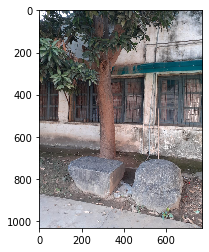

A skateboarder is grinding a rail a a a skateboard skateboard .


In [135]:
#img_name = "/content/drive/My Drive/Colab Notebooks/MAJOR/flickr8k/Flickr_Data/Flickr_Data/d.jpg"
img_name = "/content/drive/My Drive/attachments/d.jpg"
test_img = get_encoding(resnet,img_name)
caption = predict_captions(test_img)
x= plt.imread(img_name)
plt.imshow(x)
plt.show()
print(caption)